In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import osmnx as ox
import pandas as pd
import numpy as np

In [2]:
city_name = 'Dolgoprudny, Russia'
graph = ox.graph_from_place(city_name,)

## Отображение путей

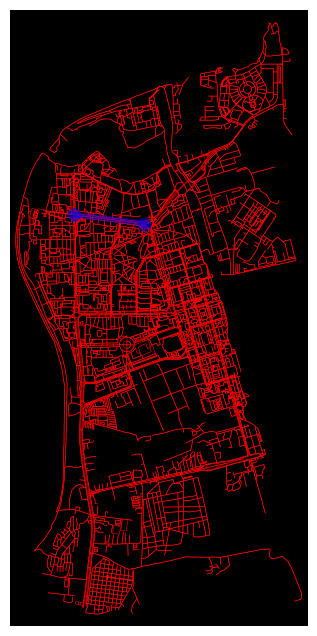

In [93]:
source_node = list(graph.nodes())[1]
target_node = list(graph.nodes())[4]
shortest_path = nx.shortest_path(graph, source=source_node, target=target_node, weight='length')
fig, ax = ox.plot_graph_route(graph, shortest_path, node_size=0, bgcolor='k', edge_color='r', edge_linewidth=0.4, route_linewidth=4, route_color='b', ax=None, show=True, close=False)

## Раскраска ребер

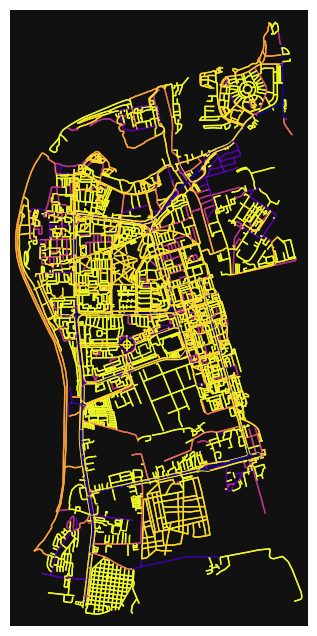

In [92]:
edges = ox.graph_to_gdfs(graph, nodes=False)
edge_types = set()
for key , value in edges['highway'].items() :
    if type(value) == type('') :
        edge_types.add(value)
edge_types.add('other')
color_list = ox.plot.get_colors(n=len(edge_types) , cmap='plasma_r')
color_mapper = pd.Series(color_list, index=edge_types).to_dict()
ec = [color_mapper[d['highway']] if type(d['highway']) == type('') else color_mapper['other'] for u, v, k, d in graph.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(graph, edge_color=ec,node_size=0.1)

In [107]:
len(ec) , len(set(ec)) ,len(color_mapper) , np.unique(ec)

(16405,
 15,
 15,
 array([0.001127, 0.006915, 0.017442, 0.029803, 0.038954, 0.050383,
        0.116492, 0.131326, 0.142453, 0.166335, 0.196158, 0.207435,
        0.221265, 0.27577 , 0.28549 , 0.32515 , 0.346251, 0.360588,
        0.406917, 0.435734, 0.444029, 0.473117, 0.527975, 0.533093,
        0.538981, 0.546157, 0.596333, 0.602065, 0.63533 , 0.639512,
        0.640959, 0.64701 , 0.659797, 0.723444, 0.74088 , 0.794549,
        0.854866, 0.85975 , 0.9128  , 0.940015, 0.95547 , 0.975158,
        0.979644, 0.985301, 0.994495, 1.      ]))

## Чекаем наиболее многочисленные дороги

In [126]:
from collections import Counter
uniq_roads = Counter(ec)
all_roads_cnt = sum(uniq_roads.values())
print("Count all roads : ",all_roads_cnt)
need_roads_colors = []
for key,value in uniq_roads.items() :
    if value > 0.05*all_roads_cnt :
        need_roads_colors.append(key)
        print("More 5% of all roads :" ,key ,value)
inverted_color_mapper = {value: key for key, value in color_mapper.items()}
need_roads_names = []
for key in need_roads_colors :
    need_roads_names.append(inverted_color_mapper[key])
    print(inverted_color_mapper[key])

Count all roads :  16405
More 5% of all roads : (0.940015, 0.975158, 0.131326, 1.0) 7141
More 5% of all roads : (0.979644, 0.854866, 0.142453, 1.0) 6428
service
footway


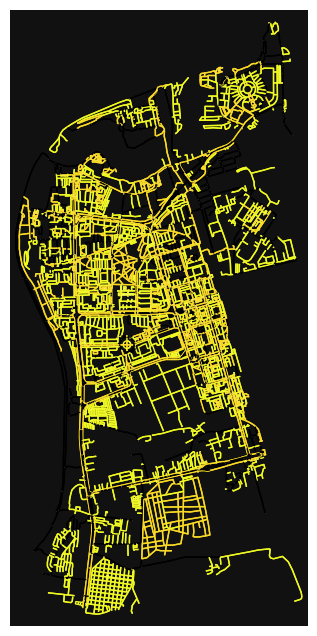

In [132]:
new_color_mapper = dict()
for key,value in color_mapper.items() :
    if key in need_roads_names:
        new_color_mapper[key] = value
new_color_mapper['other'] = color_mapper['other'] 

ec = [new_color_mapper[d['highway']] if type(d['highway']) == type('') and  d['highway'] in new_color_mapper.keys() else (0.0,0.0,0.0,1.0) for u, v, k, d in graph.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(graph, edge_color=ec,node_size=0.1)

In [102]:
unique_elements, counts = np.unique(ec, return_counts=True)
result_dict = dict(zip(unique_elements, counts))
for key,value in result_dict.items() :
    print(key , value)


0.001127 12
0.006915 631
0.017442 30
0.029803 629
0.038954 22
0.050383 629
0.116492 14
0.131326 7141
0.142453 6428
0.166335 503
0.196158 418
0.207435 30
0.221265 132
0.27577 212
0.28549 10
0.32515 631
0.346251 201
0.360588 22
0.406917 22
0.435734 12
0.444029 201
0.473117 212
0.527975 629
0.533093 10
0.538981 418
0.546157 22
0.596333 30
0.602065 14
0.63533 132
0.639512 631
0.640959 14
0.64701 22
0.659797 12
0.723444 418
0.74088 503
0.794549 212
0.854866 6428
0.85975 22
0.9128 201
0.940015 7141
0.95547 10
0.975158 7141
0.979644 6428
0.985301 132
0.994495 503
1.0 16405


## Раскраска ребер по flows or times

Загрузка данных по flows , times и графе

In [3]:
graph_table_file = '~/Desktop/TransportNet_clone/TransportNet/Stable Dynamic & Beckman/data/graph_table_test.csv' 
graph_table = pd.read_csv(graph_table_file , ' ')

nodes_file ='~/Desktop/TransportNet_clone/TransportNet/Citytograph/data/nodes_graph.csv'
nodes = pd.read_csv(nodes_file , ' ')
graph_table.head(3)

/tmp/ipykernel_1020945/2757426950.py:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  graph_table = pd.read_csv(graph_table_file , ' ')
/tmp/ipykernel_1020945/2757426950.py:5: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  nodes = pd.read_csv(nodes_file , ' ')


,Unnamed: 0,init_node,term_node,init_node_thru,term_node_thru,capacity,free_flow_time
0,0,0,18694,True,True,1.0,1.786500
1,1,0,18669,True,True,4.0,0.011896
2,2,0,4218,True,True,4.0,13.745100


In [4]:
from shapely.geometry import LineString

graph = nx.MultiDiGraph()


for node in nodes.values :
    # print(node[2],node[3])
    graph.add_node(node[0] ,x=node[2] ,y= node[3] , pos=(node[2],node[3]))
for edge in graph_table.values :
    v = edge[1]
    j = edge[2]
    # print(graph.nodes[v])
    point1 = (graph.nodes[v]['x'] , graph.nodes[v]['y'])
    point2 = (graph.nodes[j]['x'] , graph.nodes[j]['y'])
    line1 = LineString([point1, point2])
    graph.add_edge(v , j,geometry = line1)
graph.graph["crs"] = "EPSG:4326"  # Пример: WGS 84



flows

In [15]:
flows_name = '~/Desktop/TransportNet_clone/TransportNet/Stable Dynamic & Beckman/KEV_res/multi/flows/0_flows.txt'
flows = pd.read_csv(flows_name , ' ')
flows = np.array(flows)
flows = flows/max(flows)
flows = flows.T[0]

/tmp/ipykernel_1020945/1816022089.py:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  flows = pd.read_csv(flows_name , ' ')


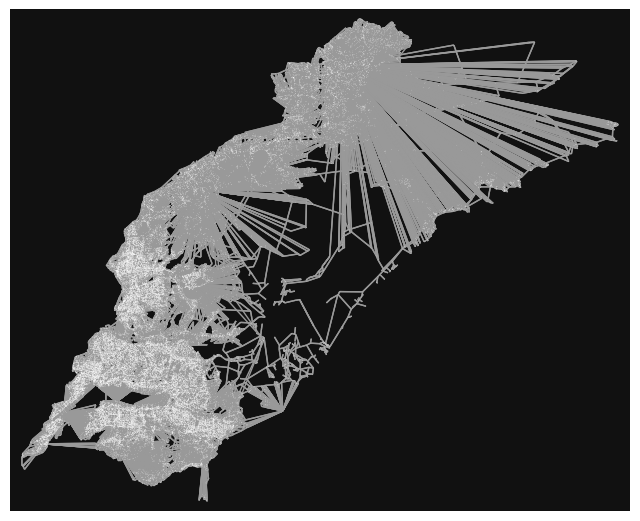

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list('green_to_red', ['green', 'red'])

# colors = cmap(flows)
fig, ax = ox.plot_graph(graph , node_size=0.1)
# fig, ax = ox.plot_graph(graph ,edge_color=colors, node_size=0.1)